<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/DataPreProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data loading
Load data from drive to colab and unzip it.

In [1]:
import os
from google.colab import drive
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image, ImageFilter, ImageChops
from matplotlib.pyplot import imshow
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import random
import shutil

In [2]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/archive.zip" -d "/content/dataset/"
dataset_path = "/content/dataset"

Mounted at /content/drive/


Print number of samples per classes and total number of images.

In [4]:
folder_path = dataset_path + "/garbage_classification/"
entries = []
for path, subdirs, files in os.walk(folder_path):
    if not files:
      continue
    entries += os.listdir(path)
    print("Number of " + os.path.basename(os.path.normpath(path)) + " images: " + str(len(os.listdir(path))))
print("Total number of images: " + str(len(entries)))

Number of clothes images: 7302
Number of plastic images: 865
Number of organic images: 985
Number of metal images: 769
Number of paper images: 1941
Number of trash images: 697
Number of glass images: 2011
Number of battery images: 945
Total number of images: 15515


Example of an image from our dataset.

/content/dataset/garbage_classification/


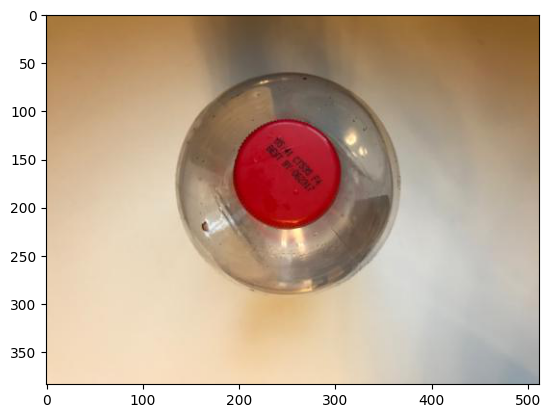

In [5]:
print(folder_path)
example_img = os.path.join(folder_path + "/plastic/", os.listdir(folder_path + "/plastic/")[0])
image = Image.open(example_img,'r')
imshow(image)

##Split dataset 

Split dataset in train, validation and test set.

In [6]:
np.random.seed(123)
np.random.shuffle(entries)
    
train_size = int(0.7 * len(entries))
val_size = int(0.15 * len(entries))

training_set = entries[0:train_size]
validation_set = entries[train_size:train_size+val_size]
test_set = entries[train_size+val_size:len(entries)]


print("Number of samples in the training set: " + str(len(training_set)))
print("Number of samples in the validation set: " + str(len(validation_set)))
print("Number of samples in the test set: " + str(len(test_set)))

Number of samples in the training set: 10860
Number of samples in the validation set: 2327
Number of samples in the test set: 2328


##Class definition and balancing

We decide to merge the classes 'white-glass', 'brown-glass' and 'green-glass', 'paper' and 'cardboard', 'clothes' and 'shoes' respectively in the classes 'glass', 'paper' and 'clothes'. Then we perform and undersampling of the class 'clothes', dropping 75% of samples. 

In [7]:
classes = ['plastic', 'glass', 'paper', 'organic', 'clothes', 'metal', 'trash', 'battery']
training_classes = {k: [] for k in classes}
validation_classes = {k: [] for k in classes}
test_classes = {k: [] for k in classes}

def split_classes(samples, labels):
  for sample in samples:
    label = str(sample).split(".")[0]
    label = ''.join([i for i in str(label) if not i.isdigit()])

    if label == 'white-glass' or label == 'brown-glass' or label == 'green-glass':
      labels['glass'].append(sample)
    elif label == 'paper' or label == 'cardboard':
      labels['paper'].append(sample)
    elif label == 'clothes' or label == 'shoes':
      labels['clothes'].append(sample)
    elif label == 'biological':
      labels['organic'].append(sample)
    else:
      labels[str(label)].append(sample)
  return labels

training_classes = split_classes(training_set, training_classes)
validation_classes = split_classes(validation_set, validation_classes)
test_classes = split_classes(test_set, test_classes)

training_classes['clothes'] = random.sample(training_classes['clothes'], int(len(training_classes['clothes'])*0.25))

In [8]:
sample_size = 0
for item in training_classes.keys():
  sample_size += len(training_classes[item])
  print(str(item) + ": " + str(len(training_classes[item])))

print(sample_size)
expected_sample_per_class = sample_size / 8
print("\nExpected sample per class: " + str(int(expected_sample_per_class)))
training_classes['clothes'] = random.sample(training_classes['clothes'], int(expected_sample_per_class))
training_classes['glass'] = random.sample(training_classes['glass'], int(expected_sample_per_class))
training_classes['paper'] = random.sample(training_classes['paper'], int(expected_sample_per_class))

print("AFTER BALANCING: \n")
sample_size = 0
for item in training_classes.keys():
  sample_size += len(training_classes[item])
  print(str(item) + ": " + str(len(training_classes[item])))

plastic: 608
glass: 1423
paper: 1354
organic: 694
clothes: 1272
metal: 545
trash: 497
battery: 651
7044

Expected sample per class: 880
AFTER BALANCING: 

plastic: 608
glass: 880
paper: 880
organic: 694
clothes: 880
metal: 545
trash: 497
battery: 651


The classes plastic, organic, metal, trash and battery have too few images, so we need to perform data augmentation to achieve the expected number of sample per class. 

# Data augmentation

In [9]:
def data_augmentation(original_image):

  if random.randint(0,1): # decide whether to flip the image or not
    horizontal = random.randint(0,1)
    if horizontal:
      new_image = tf.image.flip_left_right(original_image)
    else:
      new_image = tf.image.flip_up_down(original_image)
  else: # rotate the image of a random degree (between 90° and 270°)
    k = random.randint(1,3)
    new_image = tf.image.rot90(original_image, k)

  return np.asarray(new_image)

In [10]:
class_to_augment = ['plastic', 'organic', 'metal', 'battery', 'trash']
for c in class_to_augment:
  random_images = random.sample(training_classes[c], int(expected_sample_per_class - len(training_classes[c])))
  for img in random_images:
    name = str(img)
    img = cv2.imread(folder_path + str(c) + "/" + str(img))
    new_img = data_augmentation(img)
    cv2.imwrite(folder_path + str(c) + "/" + "aug_" + name, new_img)
    training_classes[c].append("aug_" + name)

sample_size = 0
for item in training_classes.keys():
  sample_size += len(training_classes[item])
  print(str(item) + ": " + str(len(training_classes[item])))

plastic: 880
glass: 880
paper: 880
organic: 880
clothes: 880
metal: 880
trash: 880
battery: 880


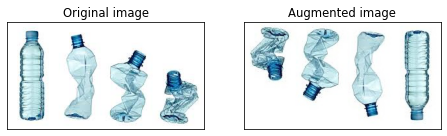

In [18]:
example_imgs = os.listdir(folder_path + "/plastic/")
example_img = random.choice([a for a in example_imgs if "aug_" in a])

aug_img = os.path.join(folder_path + "plastic/", example_img)
original_img = aug_img.replace("aug_", "")

aug_image = Image.open(aug_img)
original_image = Image.open(original_img)

fig, axs = plt.subplots(1, 2, figsize=(8, 5), dpi=70)
axs[0].imshow(original_image)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Original image')
axs[1].imshow(aug_image)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Augmented image')

plt.show()


Below you can see an example of the output of the operation just performed.

#Crop images


In [19]:
def crop_image_with_padding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    canny = cv2.Canny(gray, 50, 200)
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    center_x = int(x + w/2)
    center_y = int(y + h/2)

    height, width = img.shape[:2]
    padding = int(0.1 * min(width, height))
    new_height = height - 2*padding
    new_width = width - 2*padding

    top = max(center_y - int(new_height/2), 0)
    bottom = min(top + new_height, height)
    left = max(center_x - int(new_width/2), 0)
    right = min(left + new_width, width)

    cropped_img = img[top:bottom, left:right]
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

    return cropped_img

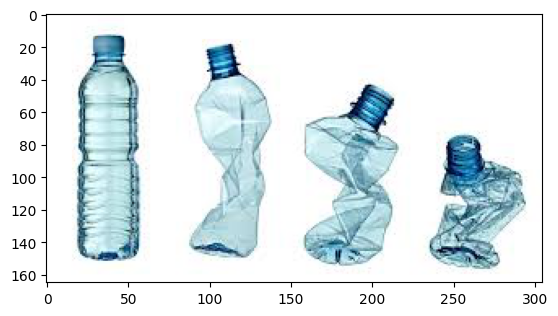

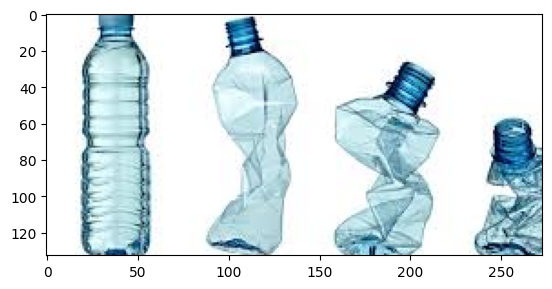

In [20]:
plt.imshow(original_image)
plt.show()
original_img = cv2.imread(aug_img.replace("aug_", ""))
crop_image = crop_image_with_padding(original_img)
plt.imshow(crop_image)
plt.show()

#Creation of directory structure and store dataset

Creation of the directory structure based on the image labels.

In [21]:
splitted_path = "content/splitted_dataset"
training_path = splitted_path + "/training_set"
validation_path = splitted_path + "/validation_set"
test_path = splitted_path + "/test_set"

shutil.rmtree(splitted_path, ignore_errors=True)

os.makedirs(training_path)
os.makedirs(validation_path)
os.makedirs(test_path)

for key in training_classes.keys():
    os.makedirs(os.path.join(training_path, key))
for key in validation_classes.keys():
    os.makedirs(os.path.join(validation_path, key))
for key in test_classes.keys():
    os.makedirs(os.path.join(test_path, key))

#Store Dataset

In [22]:
for key, value in training_classes.items(): 
  for image in value:
    img = cv2.imread(os.path.join(folder_path, key + '/' + str(image)))
    #try:
     # img = crop_image_with_padding(img)
    #except:
     # continue
    cv2.imwrite(training_path + "/" + key + '/' + str(image), img)

for key, value in validation_classes.items(): 
  for image in value:
    img = cv2.imread(os.path.join(folder_path, key + '/' + str(image)))
    #try:
     # img = crop_image_with_padding(img)
    #except:
     # continue
    cv2.imwrite(validation_path + "/" + key + '/' + str(image), img)

for key, value in test_classes.items(): 
  for image in value:
    img = cv2.imread(os.path.join(folder_path, key + '/' + str(image)))
    #try:
     # img = crop_image_with_padding(img)
    #except:
     # continue
    cv2.imwrite(test_path + "/" + key + '/' + str(image), img)

In [23]:
labels = ['battery', 'organic', 'paper', 'metal', 'plastic', 'trash', 'clothes', 'glass']
a = 0
b = 0
c = 0

for l in labels:
  a += len(os.listdir(training_path + "/" + str(l)))
  b += len(os.listdir(validation_path + "/" + str(l)))
  c += len(os.listdir(test_path + "/" + str(l)))

print("Training samples are: " + str(a))
print("Validation samples are: " + str(b))
print("Test samples are: " + str(c))

Training samples are: 7040
Validation samples are: 2327
Test samples are: 2328


In [ ]:
! zip -r "/content/drive/My Drive/project/SplittedDataset.zip" "content/splitted_dataset"

Output streaming troncato alle ultime 5000 righe.
  adding: content/splitted_dataset/kfold_set/trash/aug_trash72.jpg (deflated 8%)
  adding: content/splitted_dataset/kfold_set/trash/trash319.jpg (deflated 8%)
  adding: content/splitted_dataset/kfold_set/trash/trash629.jpg (deflated 6%)
  adding: content/splitted_dataset/kfold_set/trash/trash346.jpg (deflated 6%)
  adding: content/splitted_dataset/kfold_set/trash/aug_trash692.jpg (deflated 5%)
  adding: content/splitted_dataset/kfold_set/trash/trash502.jpg (deflated 30%)
  adding: content/splitted_dataset/kfold_set/trash/trash515.jpg (deflated 21%)
  adding: content/splitted_dataset/kfold_set/trash/trash100.jpg (deflated 18%)
  adding: content/splitted_dataset/kfold_set/trash/trash540.jpg (deflated 20%)
  adding: content/splitted_dataset/kfold_set/trash/aug_trash575.jpg (deflated 23%)
  adding: content/splitted_dataset/kfold_set/trash/trash382.jpg (deflated 7%)
  adding: content/splitted_dataset/kfold_set/trash/trash618.jpg (deflated 13